# Installations

In [ ]:
!pip install -q transformers datasets
!pip install -q pyyaml==5.4.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 12.2 MB/s eta 0:00:00
  Installing build dependencies .

# Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from datasets import Dataset
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelEncoder,  LabelBinarizer
from transformers import Trainer, TrainingArguments,  AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix , classification_report



import warnings
warnings.filterwarnings('ignore')

# Data Loading and Config Setup

In [ ]:
train = pd.read_excel("/content/Mini_Project_Dataset.xlsx")
train.rename(columns = {"Category":"label"}, inplace = True)

counts = train["label"].value_counts().reset_index()
counts = counts.sort_values(by = "index")
counts["index"] = counts["index"].astype("str")
CLASS_LABELS = counts["index"].to_list()


class config:

    MODEL_NAME = "ProsusAI/finbert"
    TOKENIZER_NAME = "ProsusAI/finbert"
    LOWER_CASE = True
    MAX_LEN = 32
    RANDOM_STATE = 12
    TEST_SIZE = 0.2
    NUM_LABELS = 10
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-5
    EPOCHS = 5
    WEIGTH_DECAY = 0.001
    DEVICE = "cuda"

# EDA

In [ ]:
fig = px.bar(
    data_frame= counts,
    x = "index",
    y = "label" ,
    color = "label" ,
    color_continuous_scale="Emrld")
fig.update_xaxes(title="Labels")
fig.update_yaxes(title = "Number of Rows")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

#the output here gives us the data distribution i.e the number of transactions
#belonging to each categories

In [ ]:
train["Words per description"] = train["Description"].str.split().apply(len)
hist = px.histogram(data_frame=train,
             x = "Words per description",
             color = "label",
             nbins =  50)

hist.update_layout(showlegend = True,
    title = {
        'text': 'Word Count Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
hist.show()

#the output here shows us the word count distribution i.e the frequency of the words per description

# Data Processing and Tokenization

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME, do_lower_case = config.LOWER_CASE)
def tokenize(batch):
    return tokenizer(batch["Description"], max_length = config.MAX_LEN, padding=True, truncation=True)

encoder = LabelEncoder()
train["label"] = encoder.fit_transform(train["label"])


dataset = Dataset.from_pandas(train[["Description", "label"]])
dataset = dataset.train_test_split(test_size = config.TEST_SIZE, seed = config.RANDOM_STATE )
dataset = dataset.map(tokenize,remove_columns=['Description'])

#The tokenizer and model weights were obtained from the HuggingFace library.
#Huggingface library is an open-source library that provides weights for a variety of pretrained transformers.

Map:   0%|          | 0/1548 [00:00<?, ? examples/s]

Map:   0%|          | 0/387 [00:00<?, ? examples/s]

# Modelling

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(config.MODEL_NAME,
                                                           num_labels=config.NUM_LABELS,
                                                           ignore_mismatched_sizes=True)
model = model.to(config.DEVICE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training Utilities

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"Accuracy": acc,
            "Precision": precision,
            "Recall":recall,
            "F1 Score": f1}


## trainning areguments
logging_steps = len(dataset["train"]) // config.BATCH_SIZE
training_args = TrainingArguments(output_dir=config.MODEL_NAME,
                                  num_train_epochs=config.EPOCHS,
                                  learning_rate=config.LEARNING_RATE,
                                  per_device_train_batch_size=config.BATCH_SIZE,
                                  per_device_eval_batch_size=config.BATCH_SIZE,
                                  weight_decay=config.WEIGTH_DECAY,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps)

# Training

In [ ]:
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset["train"],
                  eval_dataset=dataset["test"],
                  tokenizer=tokenizer)
trainer.train();

# FinBERT was trained on training data. AdamW optimizer with a learning rate of 0.00002 was used and the model was trained for 5 epochs.
#The model was evaluated on the validation set with a variety of classification metrics.
#The metrics included accuracy, precision, recall, f1 score, and AUC roc score.
#Training for a total of 5 epochs on a batch size of 32

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 score
1,1.538300,0.872304,0.813953,0.700564,0.813953,0.747335
2,0.731600,0.410444,0.950904,0.959873,0.950904,0.948555
3,0.407700,0.251600,0.979328,0.981605,0.979328,0.979522
4,0.282900,0.189297,0.981912,0.983549,0.981912,0.981946
5,0.214800,0.166976,0.981912,0.983549,0.981912,0.981946


# Model Evaluation

In [ ]:
y_test = dataset["test"]["label"]
preds = trainer.predict(dataset["test"])
metrics = preds.metrics
preds = preds.predictions
y_preds = np.argmax(preds , axis = 1 )
print("Differnt Classification Metrics score on test data:")
metrics

Differnt Classification Metrics score on test data:


{'test_loss': 0.16697551310062408,
 'test_Accuracy': 0.9819121447028424,
 'test_Precision': 0.9835492651715,
 'test_Recall': 0.9819121447028424,
 'test_F1 Score': 0.9819464471256134,
 'test_runtime': 0.6981,
 'test_samples_per_second': 554.362,
 'test_steps_per_second': 18.622}

## Confusion Matrix

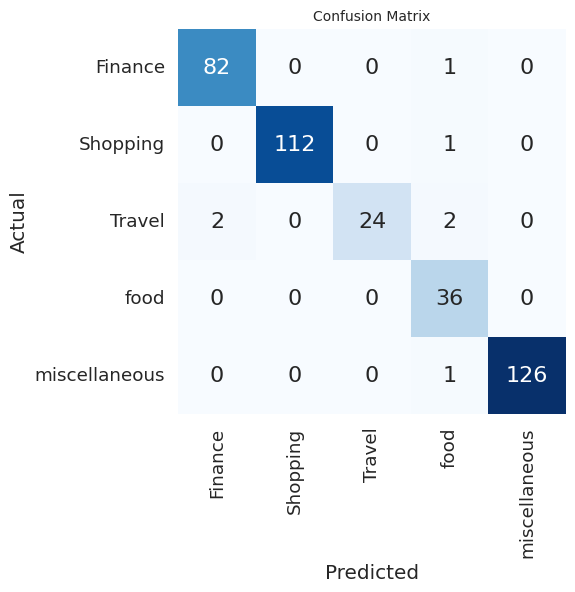

In [ ]:
cm_data = confusion_matrix(y_test , y_preds)
cm_data.shape
pd.Series(CLASS_LABELS).unique()
#CLASS_LABELS.shape
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (5,5))
plt.title('Confusion Matrix', fontsize = 10)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

## Classification Report

In [ ]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98        83
           1       1.00      0.99      1.00       113
           2       1.00      0.86      0.92        28
           3       0.88      1.00      0.94        36
           4       1.00      0.99      1.00       127

    accuracy                           0.98       387
   macro avg       0.97      0.97      0.97       387
weighted avg       0.98      0.98      0.98       387



## Multiclass ROC-AUC Curve

In [ ]:
# fig, c_ax = plt.subplots(1,1, figsize = (15,8))

# def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
#     lb = LabelBinarizer()
#     lb.fit(y_test)
#     y_test = lb.transform(y_test)
#     for (idx, c_label) in enumerate(CLASS_LABELS):
#         fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
#         c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
#     c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
#     return roc_auc_score(y_test, y_pred, average=average)

# print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
# plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
# plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
# plt.legend(fontsize = 11.5)
# plt.show();

# Predictions on Test Set

In [ ]:
test = pd.read_excel("/content/test1.xlsx")

test_dataset = Dataset.from_pandas(test[["Description"]])
test_dataset = test_dataset.map(tokenize,remove_columns=['Description'])


preds = trainer.predict(test_dataset)
preds = preds.predictions
test_preds = np.argmax(preds , axis = 1 )
test_preds = encoder.inverse_transform(test_preds)
test["Category"] = test_preds
test.to_excel("Submission.xlsx")

#The Test data is first loaded and processed in the same manner as the training data.
#Followed by processing, tokenization was done on the transaction description column.
#The tokenized data was passed on to the trained model for predictions.
#The predictions were then inverse transformed with the same encoder used for train data and replaced with the Category column of the test data.
#At last, the test data was saved as an excel file.

Map:   0%|          | 0/25 [00:00<?, ? examples/s]